In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.optim import Adam

import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from di_dataset import DepthImageDataset

from torch.utils.tensorboard import SummaryWriter

In [3]:
writer = SummaryWriter('runs/vae_cifar10')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2022-02-21 20:05:58.181210: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


cpu


/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


# Load Dataset

In [4]:
saves_folders = "../../../rl_data"
load_paths = [os.path.join(saves_folders, saves_folder) for saves_folder in os.listdir(saves_folders)]

In [5]:
# Hyperparams
input_size = 270*480
hidden_dim = 16
latent_dim = 400 
num_epochs = 3
batch_size = 10
learning_rate = 1e-3

In [6]:
# Obtain train and test data
dataset = DepthImageDataset(load_paths=load_paths)

Loading from ../../../rl_data/saves_3


100%|████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.85it/s]


Loading from ../../../rl_data/saves_1


100%|████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.15it/s]


Loading from ../../../rl_data/saves_2


100%|████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.46it/s]


In [7]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0)

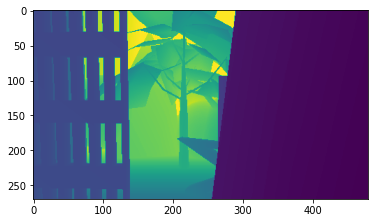

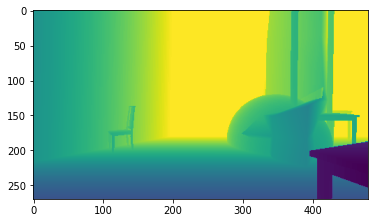

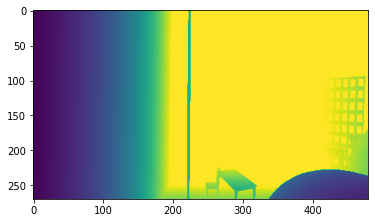

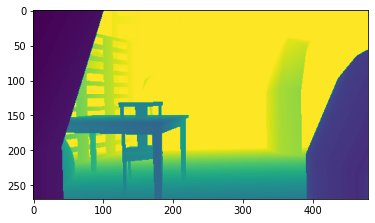

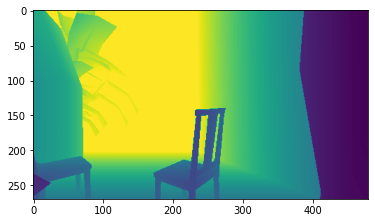

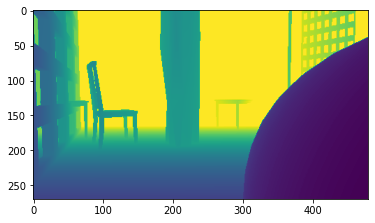

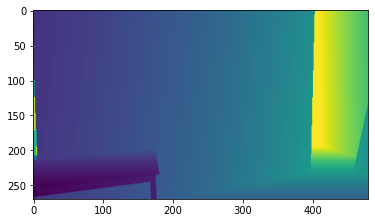

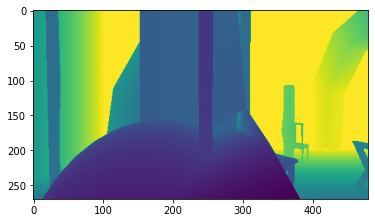

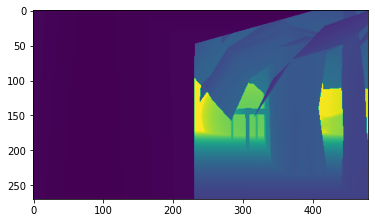

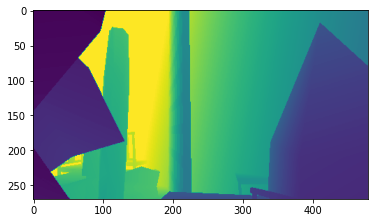

In [8]:
dataiter = iter(train_loader)
image_batch = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for image in image_batch:
    imshow(image)

# Define Variational Autoencoder


In [9]:
class Encoder(nn.Module):
    def __init__(self, input_channels, feature_dim=270*480, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=3, padding=1) # set padding 1 for feature_dim == image_size
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc_mu = nn.Linear(hidden_dim*feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim*feature_dim, latent_dim)
    
    def forward(self, x): # x = [batch_size, input_channels, 32, 32]
        x = F.relu(self.conv1(x))  # (input width - filter size + 2*padding)/stride + 1 : (32 - 3 + 2) + 1 = 32
        x = F.relu(self.conv2(x))  # x.shape = [batch, n_filters, 32, 32]
        x = x.view(-1, self.hidden_dim*270*480)
        self.mu = self.fc_mu(x)
        self.logvar = self.fc_logvar(x)
        return self.mu, self.logvar

class Decoder(nn.Module):
    def __init__(self, input_channels, feature_dim=270*480, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(Decoder, self).__init__()
        self.fc_z = nn.Linear(latent_dim, hidden_dim*feature_dim)
        self.deconv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim, input_channels, kernel_size=3, padding=1)

    def forward(self, z): # z.shape : [batch_size, latent_dim]
        x_hat = F.relu(self.fc_z(z))
        x_hat = x_hat.view(-1, hidden_dim, 270, 480)
        x_hat = F.relu(self.deconv1(x_hat))
        x_hat = torch.tanh(self.deconv2(x_hat))
        return x_hat

class VAE(nn.Module):
    def __init__(self, input_channels, feature_dim=270*480, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels=input_channels, 
                               feature_dim=feature_dim, 
                               hidden_dim=hidden_dim, 
                               latent_dim=latent_dim)
        self.decoder = Decoder(input_channels=input_channels, 
                               feature_dim=feature_dim, 
                               hidden_dim=hidden_dim, 
                               latent_dim=latent_dim)

    def forward(self, x):
        # Inference
        mu, logvar = self.encoder(x)

        # Reparametrisation
        std = torch.exp(logvar/2)
        epsilon = torch.randn_like(std) # generate eps [0,1) with dim matching std
        z = mu + std * epsilon

        # Generate
        x_hat = self.decoder(z)
        
        return mu, logvar, x_hat

In [10]:
def loss_function(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

In [11]:
n_training_samples = len(train_dataset) # 2773
n_iterations = math.ceil(n_training_samples/batch_size)
n_training_samples, n_iterations

(5547, 555)

In [ ]:
vae_model = VAE(input_channels=1)
optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    overall_loss = 0
    since = time.time()
    for i, image in enumerate(train_loader):

        optimiser.zero_grad()

        # VAE forward pass
        mu, logvar, x_hat = vae_model(image)

        # Loss
        loss = loss_function(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        loss.backward()
        optimiser.step()

        if (i+1) % 5 == 0:
            time_elapsed = time.time() - since
            #print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, image: {image.shape}")
            print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, Avg loss: {overall_loss/(i*batch_size):.3f}, time: {time_elapsed:.3f}")


In [ ]:
vae_model.eval()
with torch.no_grad():

    # Visualise sample of images
    dataiter = iter(test_loader)
    images = dataiter.next()

    # VAE forward pass
    _, _, x_hat = vae_model(images)

    index = 0
    # show images
    imshow(images[index])
    imshow(x_hat[index])

    # write to tensorboard
    # writer.add_image('four_cifar10_images', inv_normalize(img_grid))
